# 1. Import Required Libraries

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop, SGD # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

# 2. Initialize Global Variables and Helper Functions

In [20]:
SEQUENCE_LENGTH = 12
MODEL_DIR = 'clove_models'

#create model directory if it does not exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3. Data Loading and Preparation Functions

In [21]:
def load_and_prepare_data(data_path):
    """Load and prepare the clove price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders: 
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'inflation_Rate']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    rolling_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Exchange_Rate', 'inflation_Rate']
    for col in rolling_columns:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Load Data

In [22]:
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv'
df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()
df.info()

Loading data from C:/VERGER/Spice_Price_Prediction/Clove/Datasets/Clove_Dataset.csv...
Initial data shape: (1470, 17)
Columns: ['Month', 'Grade', 'Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Indonesia_Price_in_USD', 'Madagascar_Price_in_USD', 'Tanzania_Price_in_USD', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (1470, 78)
Unique grades: ['Clove' 'Stem']
Unique regions: ['Badulla' 'Colombo' 'Galle' 'Gampaha' 'Hambantota' 'Kalutara' 'Kandy'
 'Kegalle' 'Kurunegala' 'Matale' 'Matara' 'Monaragala' 'Nuwaraeliya'
 'Ratnapura']

Data loaded successfully!
Shape: (1470, 78)

First few rows:
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 5 to 1465
Data columns (total 78 columns):
 #   Column                              Non-Null Count  Dtyp

# 5. Price Distribution by Grade

<Figure size 1400x800 with 0 Axes>

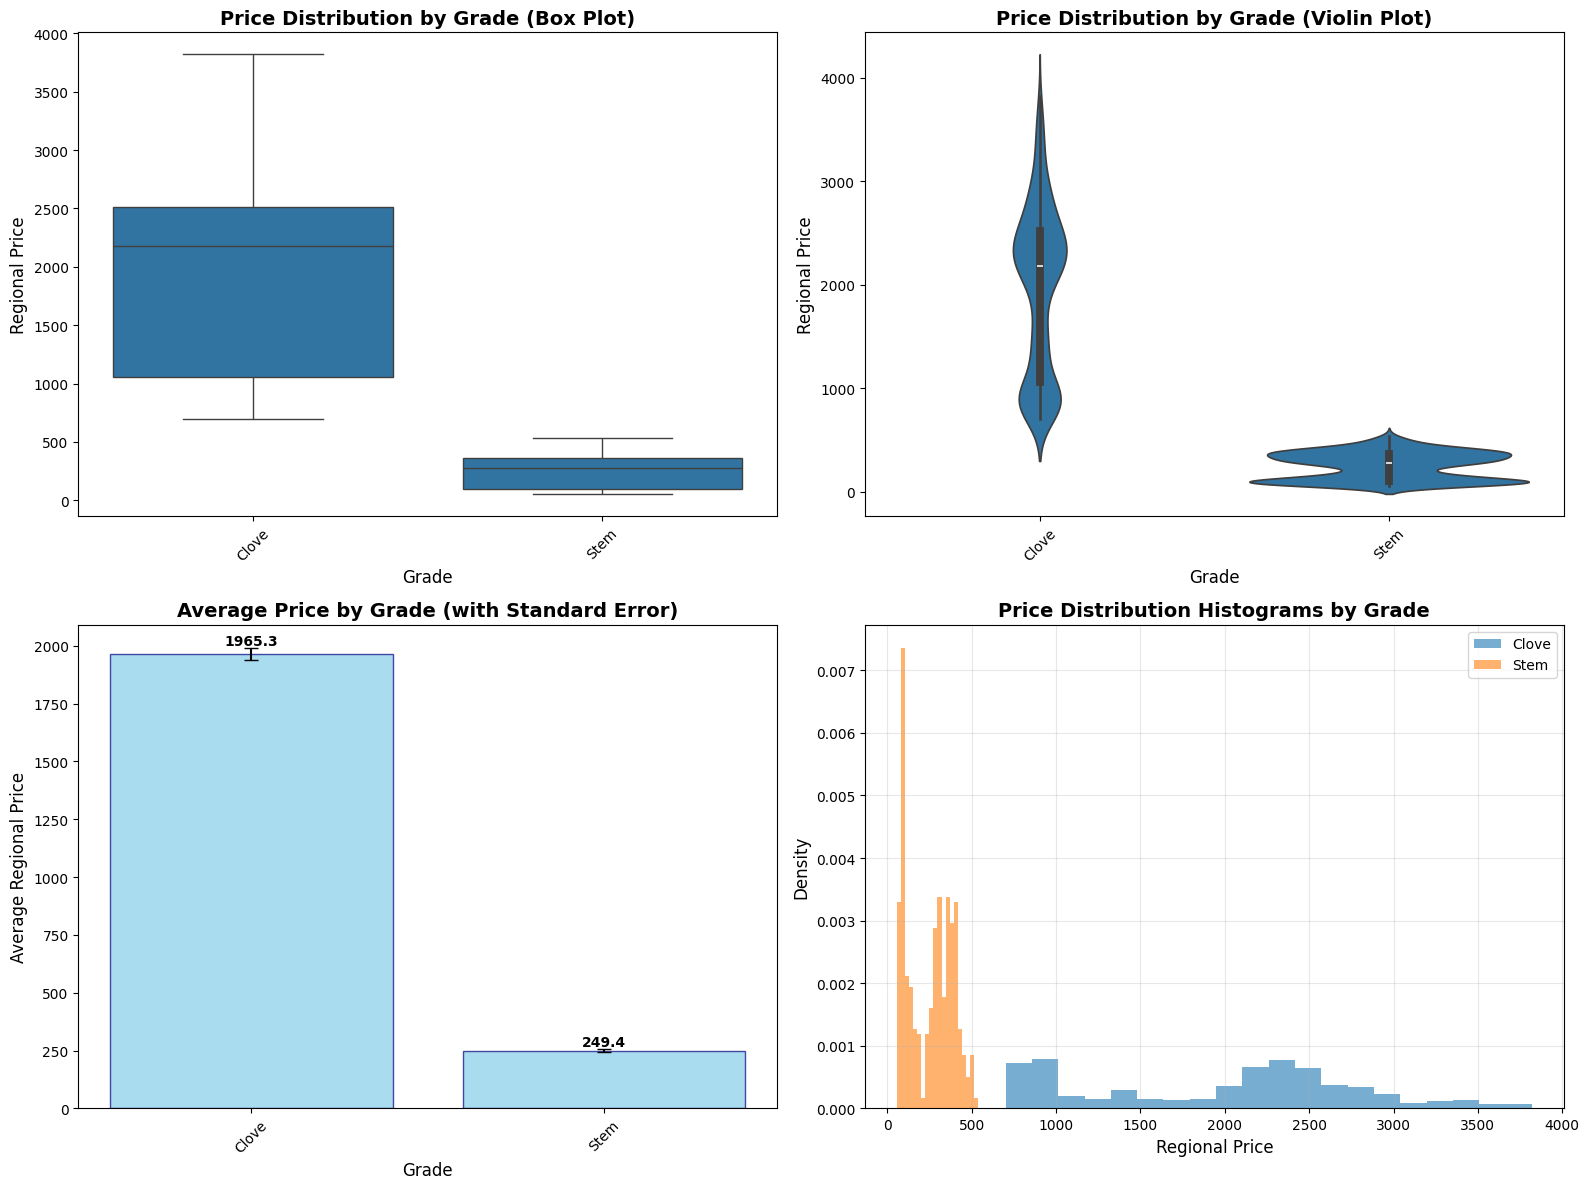


Price Distribution Summary by Grade:
       count     mean     std    min      25%      50%      75%     max
Grade                                                                  
Clove  980.0  1965.32  801.88  700.0  1058.83  2181.62  2514.50  3821.0
Stem   490.0   249.43  133.09   55.0   100.81   279.00   365.75   537.5


In [23]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)

# 6. Feature Correlation Matrix

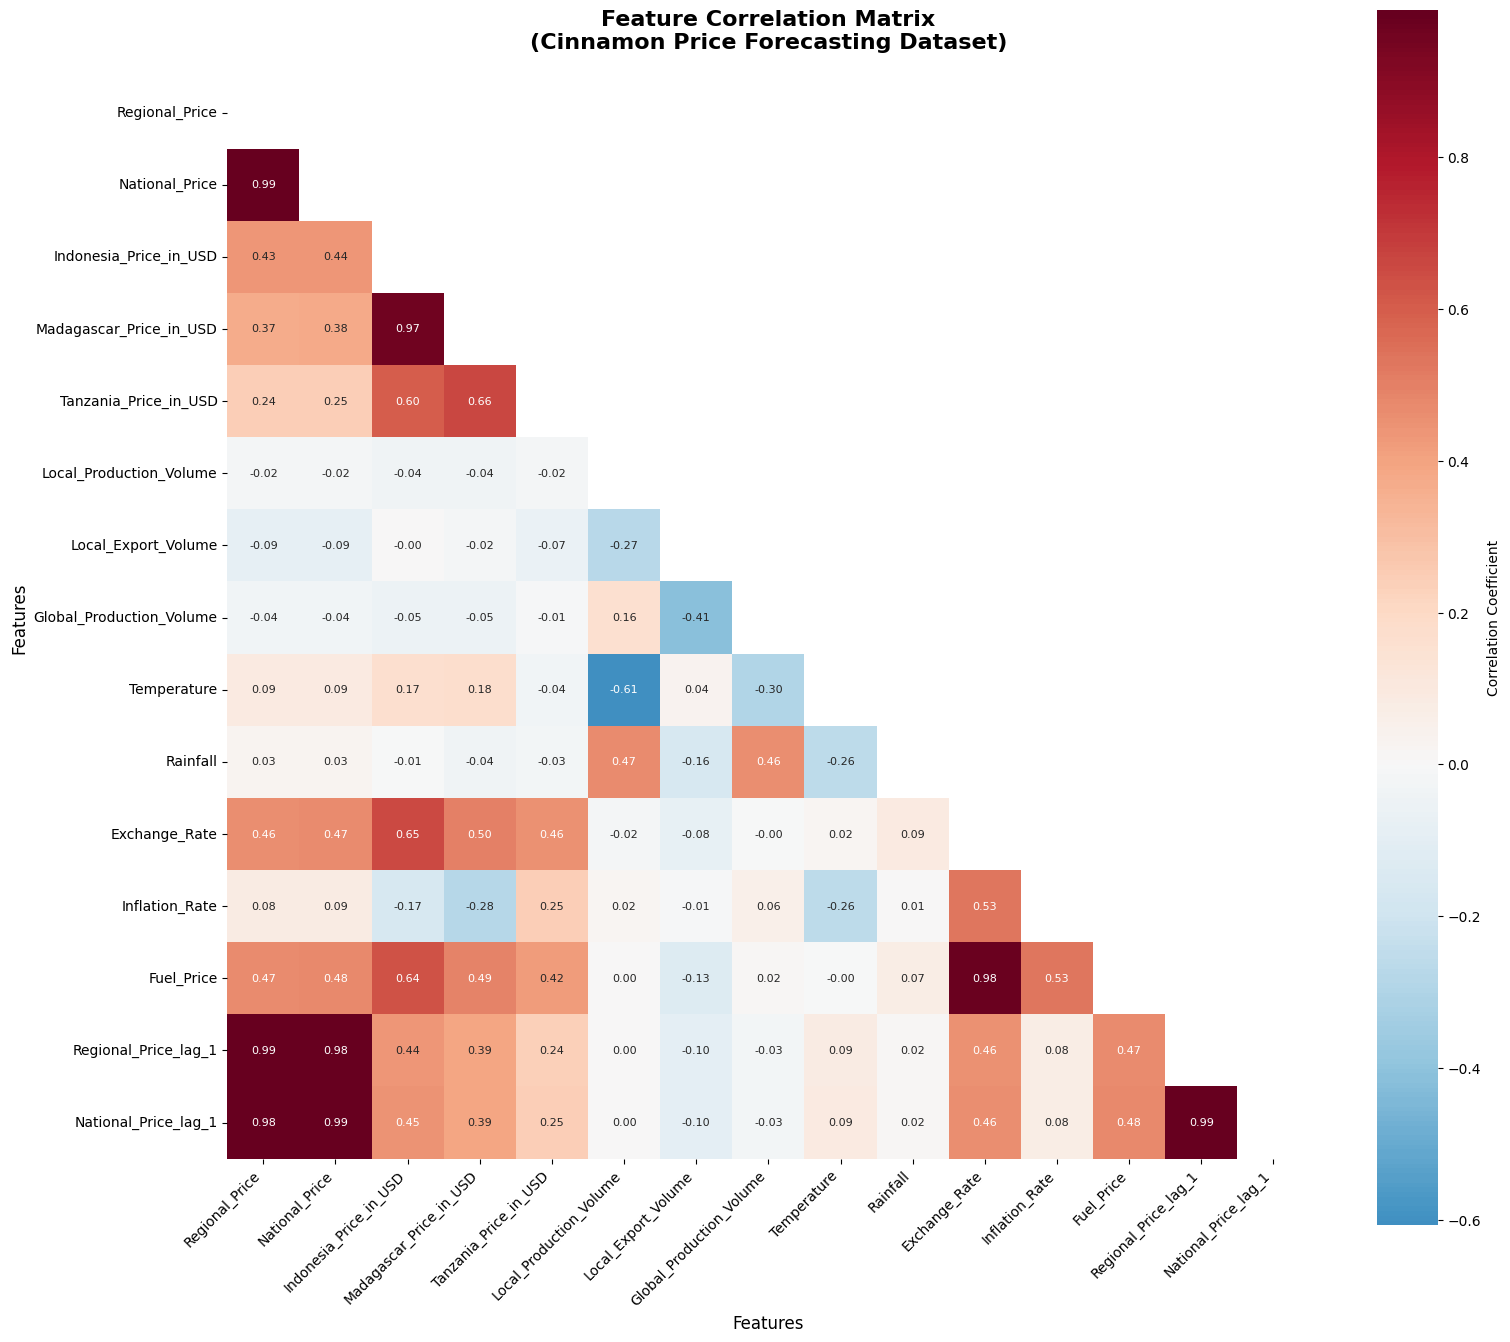


Highly Correlated Feature Pairs (|correlation| > 0.7):
National_Price ↔ National_Price_lag_1: 0.995
Regional_Price ↔ Regional_Price_lag_1: 0.991
Regional_Price ↔ National_Price: 0.989
Regional_Price_lag_1 ↔ National_Price_lag_1: 0.989
Regional_Price ↔ National_Price_lag_1: 0.984
National_Price ↔ Regional_Price_lag_1: 0.984
Exchange_Rate ↔ Fuel_Price: 0.980
Indonesia_Price_in_USD ↔ Madagascar_Price_in_USD: 0.969


In [24]:
def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    # Select numeric features for correlation analysis
    numeric_features = [
    'Regional_Price', 
    'National_Price', 
    'Indonesia_Price_in_USD', 
    'Madagascar_Price_in_USD', 
    'Tanzania_Price_in_USD',
    'Local_Production_Volume',
    'Local_Export_Volume',
    'Global_Production_Volume',
    'Temperature', 
    'Rainfall', 
    'Exchange_Rate', 
    'Inflation_Rate',
    'Fuel_Price',
    'Regional_Price_lag_1',
    'National_Price_lag_1'
]
    
    # Filter to only include columns that exist in the dataframe
    available_features = [col for col in numeric_features if col in df.columns]
    
    # Calculate correlation matrix
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Cinnamon Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated feature pairs
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

plot_feature_correlation_matrix(df)

# 7. Sequence Preparation Function for LSTM

In [25]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Instead of dropping all NaNs, fill them
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print("Total sequences created:", len(X_sequences))
    return np.array(X_sequences), np.array(y_sequences), metadata

# 8. LSTM Model Building with Hyperparameter Tuning

In [26]:
def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model with various hyperparameters"""
    model = Sequential()
    
    # Choose layer type
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:  # SimpleRNN
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:  # SimpleRNN
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
        
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # SGD
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# 9. Define Tuner Class

In [27]:
class HyperparameterTuner:
    """Hyperparameter tuning class using multiple strategies"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def grid_search_tuning(self, param_grid=None, max_trials=20):
        """Grid search hyperparameter tuning"""
        print("\n🔍 Starting Grid Search Hyperparameter Tuning...")
        print("=" * 60)
        
        if param_grid is None:
            param_grid = {
                'units1': [64, 128, 256, 512, 1024],
                'units2': [32, 64, 128, 256, 512],
                'dropout1': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dropout2': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dense_units': [16, 32, 64, 128, 256],
                'learning_rate': [0.001, 0.0005, 0.002, 0.005, 0.01],
                'layer_type': ['LSTM', 'GRU'],
                'use_batch_norm': [True, False]
            }
        
        # Generate all combinations and sample randomly if too many
        param_combinations = list(product(*param_grid.values()))
        if len(param_combinations) > max_trials:
            param_combinations = np.random.choice(
                param_combinations, size=max_trials, replace=False
            )
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        best_val_loss = float('inf')
        best_params = None
        
        for i, params in enumerate(param_combinations[:max_trials]):
            param_dict = dict(zip(param_grid.keys(), params))
            
            try:
                print(f"\nTrial {i+1}/{min(len(param_combinations), max_trials)}: {param_dict}")
                
                # Build and train model
                model = build_lstm_model_tunable(**param_dict, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': param_dict.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = param_dict.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Grid Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        # Create study and optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        # Plot optimization history
        self.plot_optuna_results(study)
        
        return study.best_params, study.best_value
    
    def plot_optuna_results(self, study):
        """Plot Optuna optimization results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot optimization history
        trials = study.trials
        values = [t.value for t in trials if t.value is not None]
        ax1.plot(values, marker='o', alpha=0.7)
        ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importance
        if len(study.trials) > 10:
            try:
                importance = optuna.importance.get_param_importances(study)
                params = list(importance.keys())
                importances = list(importance.values())
                
                ax2.barh(params, importances)
                ax2.set_title('Parameter Importance', fontsize=14, fontweight='bold')
                ax2.set_xlabel('Importance')
                ax2.grid(True, alpha=0.3)
            except:
                ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes)
        
        # Plot best value progression
        best_values = []
        current_best = float('inf')
        for trial in study.trials:
            if trial.value is not None and trial.value < current_best:
                current_best = trial.value
            best_values.append(current_best)
        
        ax3.plot(best_values, marker='o', alpha=0.7, color='green')
        ax3.set_title('Best Value Progression', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Trial')
        ax3.set_ylabel('Best Validation Loss')
        ax3.grid(True, alpha=0.3)
        
        # Distribution of validation losses
        ax4.hist(values, bins=20, alpha=0.7, edgecolor='black')
        ax4.axvline(study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
        ax4.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Validation Loss')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            # Randomly sample hyperparameters
            params = {
                'units1': np.random.choice([64, 128, 256, 512]),
                'units2': np.random.choice([32, 64, 128, 256]),
                'dropout1': np.random.uniform(0.1, 0.5),
                'dropout2': np.random.uniform(0.1, 0.5),
                'dense_units': np.random.choice([16, 32, 64, 128]),
                'learning_rate': np.random.loguniform(1e-4, 1e-2),
                'layer_type': np.random.choice(['LSTM', 'GRU']),
                'use_batch_norm': np.random.choice([True, False]),
                'optimizer': np.random.choice(['adam', 'rmsprop'])
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}: {params}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def plot_tuning_results(self):
        """Plot hyperparameter tuning results"""
        if not self.tuning_results:
            print("No tuning results to plot.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Extract data
        trials = [r['trial'] for r in self.tuning_results]
        val_losses = [r['val_loss'] for r in self.tuning_results]
        val_maes = [r['val_mae'] for r in self.tuning_results]
        
        # Plot validation loss progression
        ax1.plot(trials, val_losses, marker='o', alpha=0.7)
        ax1.set_title('Validation Loss by Trial', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot validation MAE progression
        ax2.plot(trials, val_maes, marker='s', alpha=0.7, color='orange')
        ax2.set_title('Validation MAE by Trial', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trial')
        ax2.set_ylabel('Validation MAE')
        ax2.grid(True, alpha=0.3)
        
        # Histogram of validation losses
        ax3.hist(val_losses, bins=15, alpha=0.7, edgecolor='black')
        ax3.axvline(self.best_score, color='red', linestyle='--', 
                   label=f'Best: {self.best_score:.6f}')
        ax3.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Validation Loss')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Best value progression
        best_so_far = []
        current_best = float('inf')
        for loss in val_losses:
            if loss < current_best:
                current_best = loss
            best_so_far.append(current_best)
        
        ax4.plot(trials, best_so_far, marker='o', alpha=0.7, color='green')
        ax4.set_title('Best Validation Loss Progression', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Trial')
        ax4.set_ylabel('Best Validation Loss')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# 10. Perform Hyperparameter Tuning

In [28]:
def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna', 'grid', or 'random'")
    
    # Plot results
    if method in ['grid', 'random']:
        tuner.plot_tuning_results()
    
    return best_params, best_score, tuner

# 11. LSTM Model Building Function

In [29]:
def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters from tuning"""
    if best_params is None:
        # Default parameters
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)

# 12. Training History Visualization Function

In [30]:
def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")

# 13. Model Training Function

In [31]:

def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model with best parameters
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    # Print model summary
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    
    # Use longer training for final model
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create comprehensive results dictionary
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    # Add tuning results if available
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results

# 14. Train the Model

🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING
Preparing sequences...


[I 2025-11-12 08:46:48,743] A new study created in memory with name: no-name-f7239ee2-a577-48d3-b8ce-1b4a34574255


Total sequences created: 1218
Created 1218 sequences with shape (1218, 12, 71)
Scaling features...
Training set shape: X=(730, 12, 71), y=(730,)
Validation set shape: X=(244, 12, 71), y=(244,)
Test set shape: X=(244, 12, 71), y=(244,)

🔧 Performing hyperparameter tuning using optuna method...

🚀 Starting Hyperparameter Tuning using OPTUNA method...

🎯 Starting Optuna Hyperparameter Tuning...


Best trial: 0. Best value: 0.0229194:   2%|▏         | 1/50 [00:17<14:19, 17.54s/it]

[I 2025-11-12 08:47:06,285] Trial 0 finished with value: 0.02291944809257984 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.002879078019794159, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.02291944809257984.


Best trial: 1. Best value: 0.01641:   4%|▍         | 2/50 [00:45<18:57, 23.70s/it]  

[I 2025-11-12 08:47:34,296] Trial 1 finished with value: 0.01641002669930458 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.5, 'dense_units': 64, 'learning_rate': 0.000518698002430044, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 1 with value: 0.01641002669930458.


Best trial: 1. Best value: 0.01641:   6%|▌         | 3/50 [01:29<25:55, 33.10s/it]

[I 2025-11-12 08:48:18,570] Trial 2 finished with value: 0.03423796594142914 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.00018183574790291113, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.01641002669930458.


Best trial: 3. Best value: 0.0109567:   8%|▊         | 4/50 [02:09<27:29, 35.85s/it]

[I 2025-11-12 08:48:58,641] Trial 3 finished with value: 0.01095674280077219 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.001137404569050826, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.01095674280077219.


Best trial: 3. Best value: 0.0109567:  10%|█         | 5/50 [02:24<21:12, 28.28s/it]

[I 2025-11-12 08:49:13,502] Trial 4 finished with value: 0.04661915823817253 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.00011932832843312359, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.01095674280077219.


Best trial: 3. Best value: 0.0109567:  12%|█▏        | 6/50 [02:47<19:28, 26.55s/it]

[I 2025-11-12 08:49:36,689] Trial 5 finished with value: 0.01790192723274231 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.00027075556184698465, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.01095674280077219.


Best trial: 3. Best value: 0.0109567:  14%|█▍        | 7/50 [03:39<24:51, 34.68s/it]

[I 2025-11-12 08:50:28,097] Trial 6 finished with value: 0.022007212042808533 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0007819813670959383, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.01095674280077219.


Best trial: 3. Best value: 0.0109567:  16%|█▌        | 8/50 [04:15<24:34, 35.12s/it]

[I 2025-11-12 08:51:04,160] Trial 7 finished with value: 0.012984379194676876 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.00122456020444158, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.01095674280077219.


Best trial: 3. Best value: 0.0109567:  18%|█▊        | 9/50 [04:36<20:54, 30.61s/it]

[I 2025-11-12 08:51:24,850] Trial 8 finished with value: 0.01226762868463993 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0015806208477398102, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.01095674280077219.


Best trial: 3. Best value: 0.0109567:  20%|██        | 10/50 [05:04<19:50, 29.77s/it]

[I 2025-11-12 08:51:52,759] Trial 9 finished with value: 0.01850474625825882 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.008711577748522808, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.01095674280077219.


Best trial: 10. Best value: 0.0106903:  22%|██▏       | 11/50 [05:34<19:33, 30.10s/it]

[I 2025-11-12 08:52:23,581] Trial 10 finished with value: 0.010690251365303993 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0040659597991354254, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 10 with value: 0.010690251365303993.


Best trial: 10. Best value: 0.0106903:  24%|██▍       | 12/50 [06:07<19:32, 30.85s/it]

[I 2025-11-12 08:52:56,154] Trial 11 finished with value: 0.01077097374945879 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0044896814893511825, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 10 with value: 0.010690251365303993.


Best trial: 10. Best value: 0.0106903:  26%|██▌       | 13/50 [06:39<19:20, 31.35s/it]

[I 2025-11-12 08:53:28,663] Trial 12 finished with value: 0.010982009582221508 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.006386018563699582, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 10 with value: 0.010690251365303993.


Best trial: 10. Best value: 0.0106903:  28%|██▊       | 14/50 [07:12<19:00, 31.69s/it]

[I 2025-11-12 08:54:01,122] Trial 13 finished with value: 0.010838132351636887 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0035949844165677983, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 10 with value: 0.010690251365303993.


Best trial: 14. Best value: 0.0100116:  30%|███       | 15/50 [07:39<17:41, 30.34s/it]

[I 2025-11-12 08:54:28,341] Trial 14 finished with value: 0.010011637583374977 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0032855592738561122, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  32%|███▏      | 16/50 [08:07<16:41, 29.46s/it]

[I 2025-11-12 08:54:55,751] Trial 15 finished with value: 0.013393126428127289 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.002503919634066251, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  34%|███▍      | 17/50 [08:37<16:25, 29.86s/it]

[I 2025-11-12 08:55:26,535] Trial 16 finished with value: 0.010539180599153042 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0018159348983463224, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  36%|███▌      | 18/50 [09:05<15:33, 29.18s/it]

[I 2025-11-12 08:55:54,142] Trial 17 finished with value: 0.015200597234070301 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0005304709468301764, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  38%|███▊      | 19/50 [09:27<13:58, 27.06s/it]

[I 2025-11-12 08:56:16,261] Trial 18 finished with value: 0.014833926223218441 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 16, 'learning_rate': 0.0019236622596342794, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  40%|████      | 20/50 [09:56<13:51, 27.71s/it]

[I 2025-11-12 08:56:45,477] Trial 19 finished with value: 0.014268722385168076 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.000753430282605465, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  42%|████▏     | 21/50 [10:23<13:18, 27.53s/it]

[I 2025-11-12 08:57:12,593] Trial 20 finished with value: 0.01221055630594492 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.006385022474556177, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  44%|████▍     | 22/50 [10:46<12:08, 26.01s/it]

[I 2025-11-12 08:57:35,058] Trial 21 finished with value: 0.011787251569330692 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0048000688108863, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  46%|████▌     | 23/50 [11:10<11:26, 25.43s/it]

[I 2025-11-12 08:57:59,150] Trial 22 finished with value: 0.010917065665125847 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0020838106673025116, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  48%|████▊     | 24/50 [11:35<10:55, 25.22s/it]

[I 2025-11-12 08:58:23,878] Trial 23 finished with value: 0.011814145371317863 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.003485655587050242, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  50%|█████     | 25/50 [12:02<10:48, 25.92s/it]

[I 2025-11-12 08:58:51,428] Trial 24 finished with value: 0.012122814543545246 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00977050510325294, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  52%|█████▏    | 26/50 [12:20<09:24, 23.51s/it]

[I 2025-11-12 08:59:09,329] Trial 25 finished with value: 0.019856510683894157 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0015647860850664629, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  54%|█████▍    | 27/50 [12:47<09:21, 24.42s/it]

[I 2025-11-12 08:59:35,856] Trial 26 finished with value: 0.022876298055052757 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.005392547350058717, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  56%|█████▌    | 28/50 [13:11<08:55, 24.36s/it]

[I 2025-11-12 09:00:00,086] Trial 27 finished with value: 0.01832575909793377 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0028609304832531005, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  58%|█████▊    | 29/50 [13:42<09:14, 26.40s/it]

[I 2025-11-12 09:00:31,238] Trial 28 finished with value: 0.01932012476027012 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.003944846981919377, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  60%|██████    | 30/50 [14:24<10:21, 31.09s/it]

[I 2025-11-12 09:01:13,284] Trial 29 finished with value: 0.018255284056067467 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0026028544393131635, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 14. Best value: 0.0100116:  62%|██████▏   | 31/50 [15:07<10:59, 34.69s/it]

[I 2025-11-12 09:01:56,359] Trial 30 finished with value: 0.01064954325556755 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0015456592588366659, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 14 with value: 0.010011637583374977.


Best trial: 31. Best value: 0.00995173:  64%|██████▍   | 32/50 [15:49<11:02, 36.83s/it]

[I 2025-11-12 09:02:38,194] Trial 31 finished with value: 0.009951733984053135 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0016610216968835263, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  66%|██████▌   | 33/50 [16:16<09:38, 34.03s/it]

[I 2025-11-12 09:03:05,685] Trial 32 finished with value: 0.011269986629486084 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00091813083321624, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  68%|██████▊   | 34/50 [16:56<09:31, 35.73s/it]

[I 2025-11-12 09:03:45,365] Trial 33 finished with value: 0.010068451054394245 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0014092188981618694, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  70%|███████   | 35/50 [17:42<09:40, 38.69s/it]

[I 2025-11-12 09:04:30,983] Trial 34 finished with value: 0.011180249974131584 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.000607925249737859, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  72%|███████▏  | 36/50 [18:44<10:42, 45.87s/it]

[I 2025-11-12 09:05:33,612] Trial 35 finished with value: 0.010760181583464146 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.00039979232698609667, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  74%|███████▍  | 37/50 [19:20<09:15, 42.71s/it]

[I 2025-11-12 09:06:08,939] Trial 36 finished with value: 0.024540474638342857 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.00118502088404854, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  76%|███████▌  | 38/50 [20:10<09:01, 45.12s/it]

[I 2025-11-12 09:06:59,676] Trial 37 finished with value: 0.021842297166585922 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.001989451952656384, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  78%|███████▊  | 39/50 [20:51<08:00, 43.72s/it]

[I 2025-11-12 09:07:40,149] Trial 38 finished with value: 0.01104723196476698 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.00036686550036129343, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  80%|████████  | 40/50 [21:16<06:21, 38.19s/it]

[I 2025-11-12 09:08:05,408] Trial 39 finished with value: 0.02116507478058338 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0009929519720045512, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  82%|████████▏ | 41/50 [22:14<06:37, 44.17s/it]

[I 2025-11-12 09:09:03,559] Trial 40 finished with value: 0.011789444833993912 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0013797680958857175, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  84%|████████▍ | 42/50 [23:01<05:59, 44.95s/it]

[I 2025-11-12 09:09:50,328] Trial 41 finished with value: 0.010291890241205692 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0018953012705246772, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  86%|████████▌ | 43/50 [23:47<05:16, 45.16s/it]

[I 2025-11-12 09:10:35,962] Trial 42 finished with value: 0.010411850176751614 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0022877251622261115, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 31. Best value: 0.00995173:  88%|████████▊ | 44/50 [24:32<04:31, 45.28s/it]

[I 2025-11-12 09:11:21,536] Trial 43 finished with value: 0.010370523668825626 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0023275452104935717, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.009951733984053135.


Best trial: 44. Best value: 0.00983964:  90%|█████████ | 45/50 [25:19<03:47, 45.60s/it]

[I 2025-11-12 09:12:07,860] Trial 44 finished with value: 0.009839638136327267 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.003176430796335916, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 44 with value: 0.009839638136327267.


Best trial: 44. Best value: 0.00983964:  92%|█████████▏| 46/50 [26:00<02:57, 44.41s/it]

[I 2025-11-12 09:12:49,510] Trial 45 finished with value: 0.010621188208460808 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0031256451819434935, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 44 with value: 0.009839638136327267.


Best trial: 44. Best value: 0.00983964:  94%|█████████▍| 47/50 [26:42<02:11, 43.74s/it]

[I 2025-11-12 09:13:31,701] Trial 46 finished with value: 0.012578370980918407 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.00015399630840091, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 44 with value: 0.009839638136327267.


Best trial: 44. Best value: 0.00983964:  96%|█████████▌| 48/50 [28:20<01:59, 59.93s/it]

[I 2025-11-12 09:15:09,390] Trial 47 finished with value: 0.015168510377407074 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0012389370283068719, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 44 with value: 0.009839638136327267.


Best trial: 48. Best value: 0.00964375:  98%|█████████▊| 49/50 [29:11<00:57, 57.28s/it]

[I 2025-11-12 09:16:00,492] Trial 48 finished with value: 0.009643753059208393 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002878801558413158, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 48 with value: 0.009643753059208393.


Best trial: 48. Best value: 0.00964375: 100%|██████████| 50/50 [29:59<00:00, 35.99s/it]


[I 2025-11-12 09:16:48,054] Trial 49 finished with value: 0.012159711681306362 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.006983271262217796, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 48 with value: 0.009643753059208393.

🎉 Optuna Tuning Complete!
Best validation loss: 0.009644
Best parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002878801558413158, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}


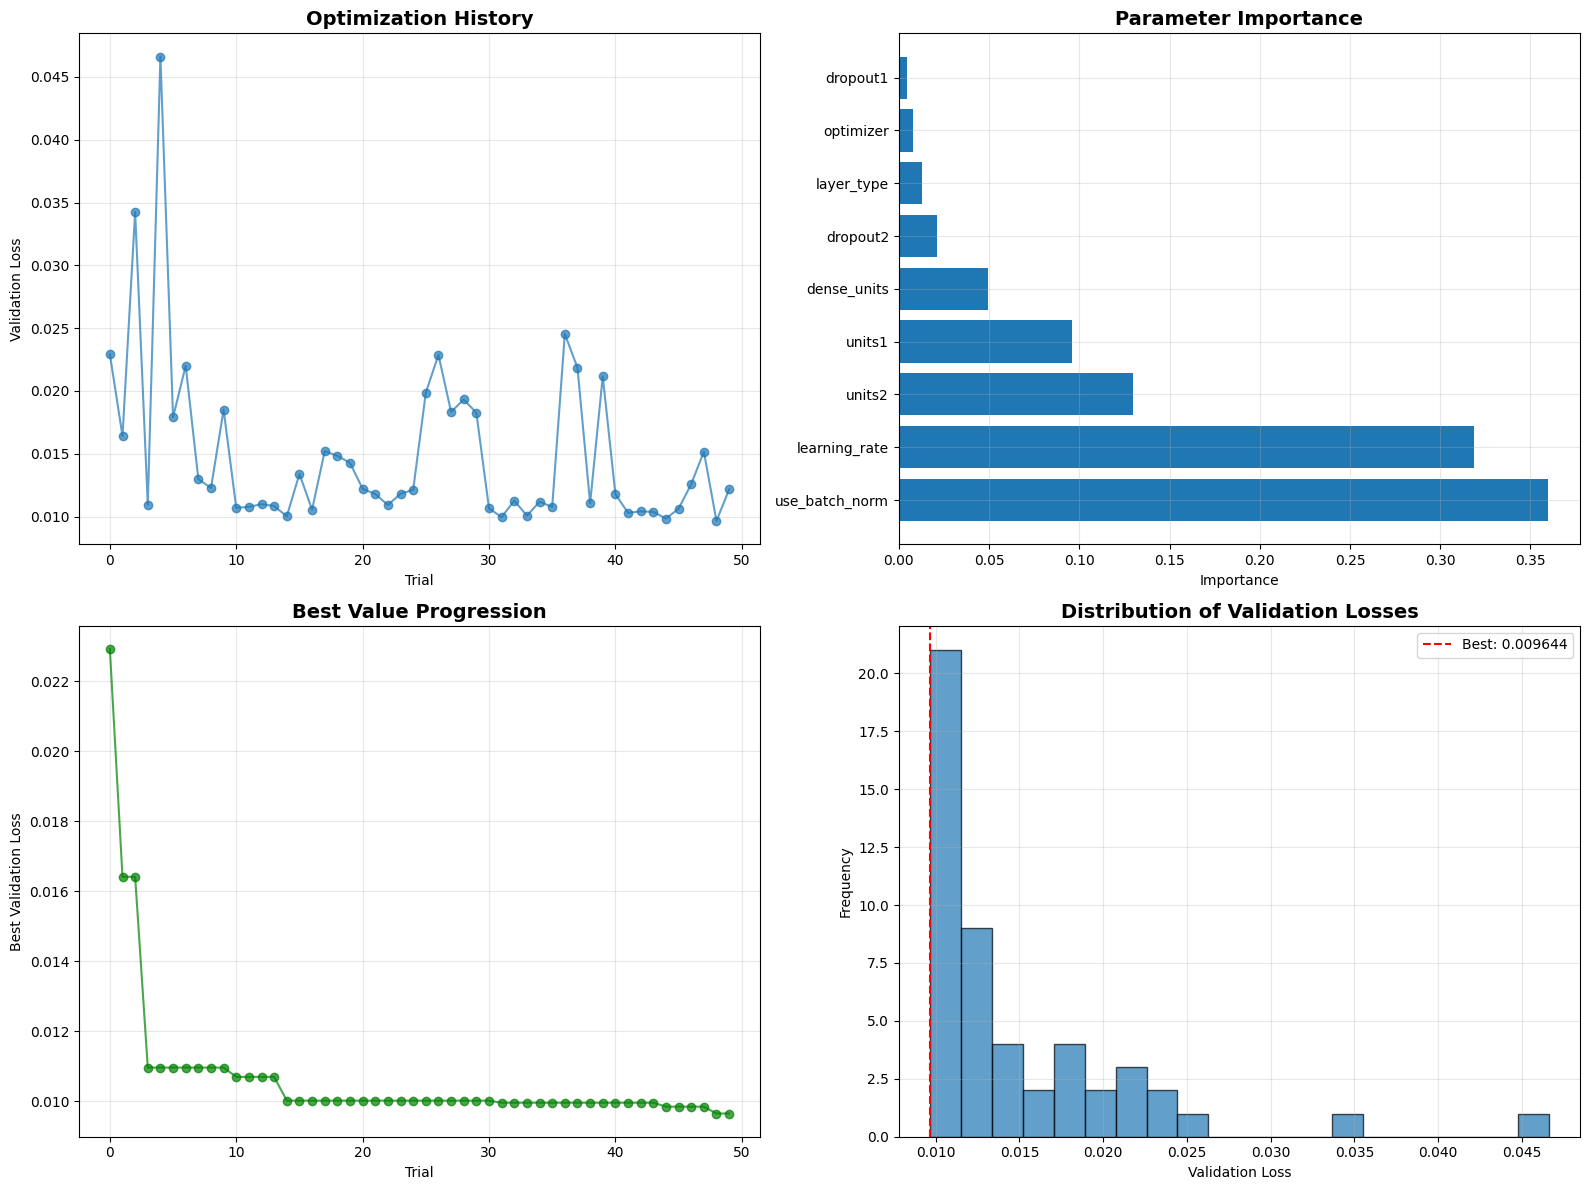


📊 Hyperparameter Tuning Results:
Best validation loss: 0.009644
Best parameters:
  units1: 128
  units2: 256
  dropout1: 0.1
  dropout2: 0.2
  dense_units: 64
  learning_rate: 0.002878801558413158
  layer_type: GRU
  use_batch_norm: False
  optimizer: adam

Building final model with optimized parameters...

📋 Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 128)        │        77,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,145 (1.49 MB)

 Trainable params: 390,145 (1.49 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.2411 - mae: 0.3658 - val_loss: 0.0806 - val_mae: 0.2256 - learning_rate: 0.0029
Epoch 2/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0509 - mae: 0.1771 - val_loss: 0.0292 - val_mae: 0.1359 - learning_rate: 0.0029
Epoch 3/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0378 - mae: 0.1540 - val_loss: 0.0261 - val_mae: 0.1261 - learning_rate: 0.0029
Epoch 4/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0397 - mae: 0.1535 - val_loss: 0.0208 - val_mae: 0.1062 - learning_rate: 0.0029
Epoch 5/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0302 - mae: 0.1348 - val_loss: 0.0228 - val_mae: 0.1173 - learning_rate: 0.0029
Epoch 6/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0267 - mae: 0.1265 - val_loss: 0.0174 - val_mae: 0.1070 - learning_rate: 0.0029
Epoch 7/150
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0241 - mae: 0.1192 - val_loss: 0.0163 - val_mae: 0.0930 - lea

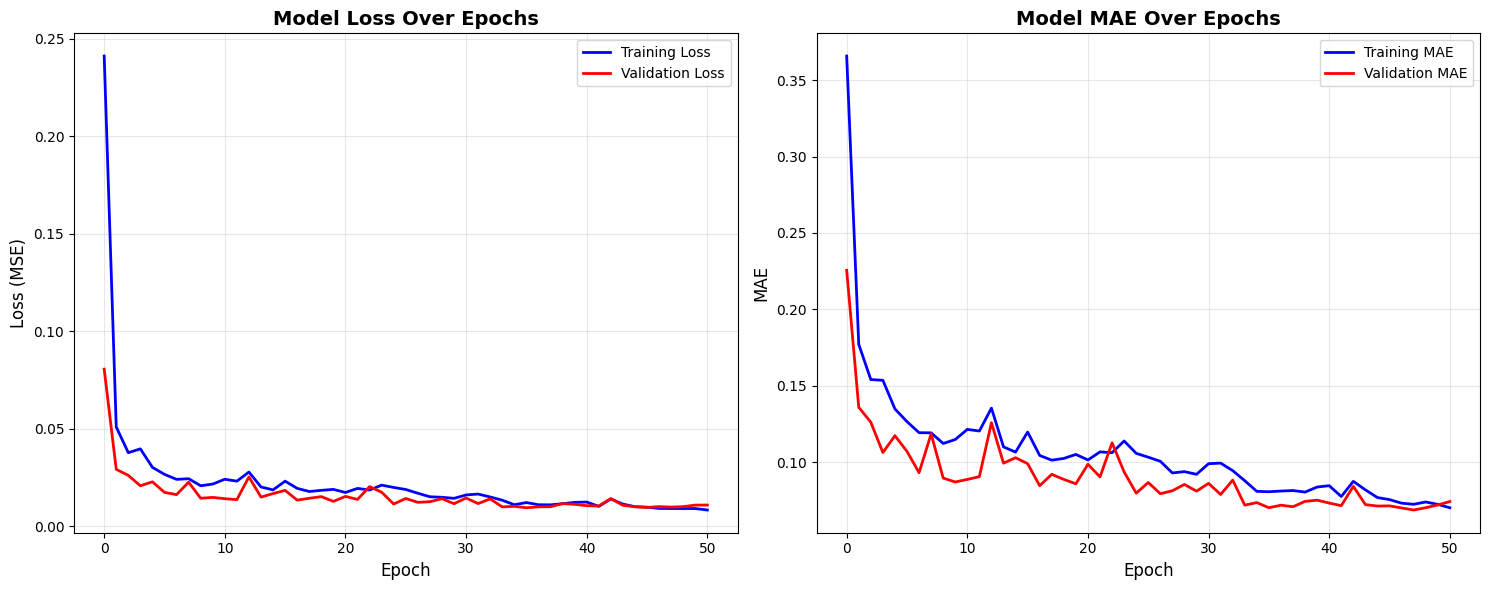


Final Training Metrics:
Training Loss: 0.0084
Validation Loss: 0.0109
Training MAE: 0.0701
Validation MAE: 0.0741

Evaluating final model on test set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

🎯 Final Model Performance on Test Set:
MAE: 91.14
RMSE: 130.04
R²: 0.9842

🎉 Model training completed!


In [32]:
# Train model with hyperparameter tuning
print("🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*80)

# You can change these parameters:
USE_HYPERPARAMETER_TUNING = True  # Set to False to skip tuning
TUNING_METHOD = 'optuna'  # Options: 'optuna', 'grid', 'random'
N_TUNING_TRIALS = 50  # Number of trials for tuning

model, history, metrics = train_model(
    df, 
    use_tuning=USE_HYPERPARAMETER_TUNING,
    tuning_method=TUNING_METHOD,
    n_tuning_trials=N_TUNING_TRIALS
)

print("\n🎉 Model training completed!")

# 15. Save the Model

In [33]:
def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and all preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create model-specific directory
    model_save_dir = os.path.join(model_dir, f"clove_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n📁 Saving model to: {model_save_dir}")
    
    try:
        # 1. Save the Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # 2. Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # 3. Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # 4. Save model configuration and metadata (enhanced with tuning info)
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2']),
                'tuning_used': metrics.get('tuning_used', False),
                'tuning_method': metrics.get('tuning_method', None),
                'best_params': metrics.get('best_params', None),
                'epochs_trained': metrics.get('epochs_trained', 0),
                'final_train_loss': float(metrics.get('final_train_loss', 0)),
                'final_val_loss': float(metrics.get('final_val_loss', 0))
            }
        }
        
        # Save tuning results if available
        if 'tuning_results' in metrics and metrics['tuning_results']:
            tuning_results_path = os.path.join(model_save_dir, "tuning_results.json")
            with open(tuning_results_path, 'w') as f:
                json.dump(metrics['tuning_results'], f, indent=2, default=str)
            print(f"✅ Hyperparameter tuning results saved: tuning_results.json")
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        
        # Print summary of saved model
        print(f"\n📊 Saved Model Summary:")
        print(f"  • Performance: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
        if metrics.get('tuning_used'):
            print(f"  • Hyperparameter tuning: {metrics['tuning_method']} method used")
            print(f"  • Best parameters found and applied")
        print(f"  • Training epochs: {metrics.get('epochs_trained', 'N/A')}")
        print(f"  • Total parameters: {model.count_params():,}")
        
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('tuning_used'):
            print(f"🔧 This model was trained with {config['training_info']['tuning_method']} hyperparameter tuning")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None
    
saved_model_path=save_model(model, metrics)
print(f"Model saved at: {saved_model_path}")


📁 Saving model to: clove_models\clove_model_20251112_100700
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: clove_models\clove_model_20251112_100700

📊 Saved Model Summary:
  • Performance: MAE=91.14, RMSE=130.04, R²=0.9842
  • Hyperparameter tuning: optuna method used
  • Best parameters found and applied
  • Training epochs: 51
  • Total parameters: 390,145
Model saved at: clove_models\clove_model_20251112_100700
